In [2]:
# Constants

months_list = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 
               'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
invalid_value = -999

In [160]:
# Imports

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal
import contextily
import xarray
import datashader
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pointpats import centrography

In [4]:
# Get all csv files in the burn_folder

directory = os.getcwd()
burn_folder = os.path.join(directory, "data")
csv_files = os.listdir(burn_folder)

print("Reading {} files...".format(len(csv_files)))

column_types = {
    'precipitacao': 'float32',
    'riscofogo': 'float32',
    'latitude': 'float64',
    'longitude': 'float64',
    'frp': 'float64'
}

# Create the DataFrame from csv
df = pd.concat(
    [pd.read_csv(os.path.join(burn_folder, f), parse_dates=["datahora"], dtype=column_types) for f in csv_files], 
    ignore_index=True
  )

# optimize data and setup types
print("Optimizing dataframe: {}".format(df.shape))
df['diasemchuva'] = df['diasemchuva'].fillna(invalid_value).astype("int16")
df.loc[df.riscofogo == invalid_value, 'riscofogo'] = 0
df['riscofogo'] = df['riscofogo'].fillna(0).astype("bool")
df['satelite'] = df['satelite'].astype("category")
df['pais'] = df['pais'].astype("category")
df['estado'] = df['estado'].astype("category")
df['municipio'] = df['municipio'].astype("category")
df['bioma'] = df['bioma'].astype("category")

df['date'] = df['datahora'].dt.date
df['hora'] = df['datahora'].dt.time
df['dia'] = df['datahora'].dt.day
df['mes'] = df['datahora'].dt.month
df['ano'] = df['datahora'].dt.year

df.info()

Reading 300 files...
Optimizing dataframe: (43782758, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43782758 entries, 0 to 43782757
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   datahora      datetime64[ns]
 1   satelite      category      
 2   pais          category      
 3   estado        category      
 4   municipio     category      
 5   bioma         category      
 6   diasemchuva   int16         
 7   precipitacao  float32       
 8   riscofogo     bool          
 9   latitude      float64       
 10  longitude     float64       
 11  frp           float64       
 12  date          object        
 13  hora          object        
 14  dia           int64         
 15  mes           int64         
 16  ano           int64         
dtypes: bool(1), category(5), datetime64[ns](1), float32(1), float64(3), int16(1), int64(3), object(2)
memory usage: 3.5+ GB


In [5]:
# Processamento dos satelites

# Muitos satélites podem ser simplificados
satelite_map = {
  'NPP-375D': 'NPP-375',
  'AQUA_M-T': 'AQUA_M',
  'AQUA_M-M': 'AQUA_M',
  'TERRA_M-T': 'TERRA_M',
  'TERRA_M-M': 'TERRA_M',
  'NOAA-18D': 'NOAA-18',
  'NOAA-19D': 'NOAA-19',
  'NOAA-16N': 'NOAA-16',
  'NOAA-15D': 'NOAA-15',
  'NOAA-12D': 'NOAA-12'
}
df['simp_satelite'] = df['satelite'].map(satelite_map).fillna(df['satelite']).astype("category")

In [117]:
# variaveis derivadas dos dados
import random

all_satellites = df['satelite'].value_counts().index.values
simp_satellites = df['simp_satelite'].value_counts().index.values

simp_satellites_rand = simp_satellites.tolist()
random.shuffle(simp_satellites_rand)
cmap = plt.cm.get_cmap('hsv', len(simp_satellites_rand))
satellites_colors = {}
for (i, satelite) in enumerate(simp_satellites_rand):
    satellites_colors[satelite] = cmap(i)

satellites_colors

{'NOAA-16': (1.0, 0.0, 0.0, 1.0),
 'TERRA_M': (1.0, 0.28125028125028123, 0.0, 1.0),
 'NOAA-12': (1.0, 0.5625005625005625, 0.0, 1.0),
 'NOAA-15': (1.0, 0.8437508437508436, 0.0, 1.0),
 'NOAA-19': (0.8749988749988751, 1.0, 0.0, 1.0),
 'AQUA_M': (0.5937485937485938, 1.0, 0.0, 1.0),
 'GOES-16': (0.3124983124983125, 1.0, 0.0, 1.0),
 'MSG-02': (0.031249343749343742, 1.0, 1.3125013125182355e-06, 1.0),
 'MSG-03': (0.0, 1.0, 0.2500010687443356, 1.0),
 'NOAA-14': (0.0, 1.0, 0.5312495781272359, 1.0),
 'NOAA-20': (0.0, 1.0, 0.8124980875101362, 1.0),
 'METOP-C': (0.0, 0.906252812502813, 1.0, 1.0),
 'NOAA-18': (0.0, 0.6250025312525312, 1.0, 1.0),
 'METOP-B': (0.0, 0.34375225000224996, 1.0, 1.0),
 'GOES-08': (0.0, 0.06250196875196878, 1.0, 1.0),
 'GOES-12': (0.21874831249831164, 0.0, 1.0, 1.0),
 'TRMM': (0.4999985937485935, 0.0, 1.0, 1.0),
 'NPP-375': (0.781248874998875, 0.0, 1.0, 1.0),
 'ATSR': (0.9999997187497188, 0.0, 0.9375005625005625, 1.0),
 'NOAA-17': (1.0, 0.0, 0.6562505625005635, 1.0),
 'GOES

<AxesSubplot: title={'center': 'Quantitativo de ano de 2021'}, xlabel='date'>

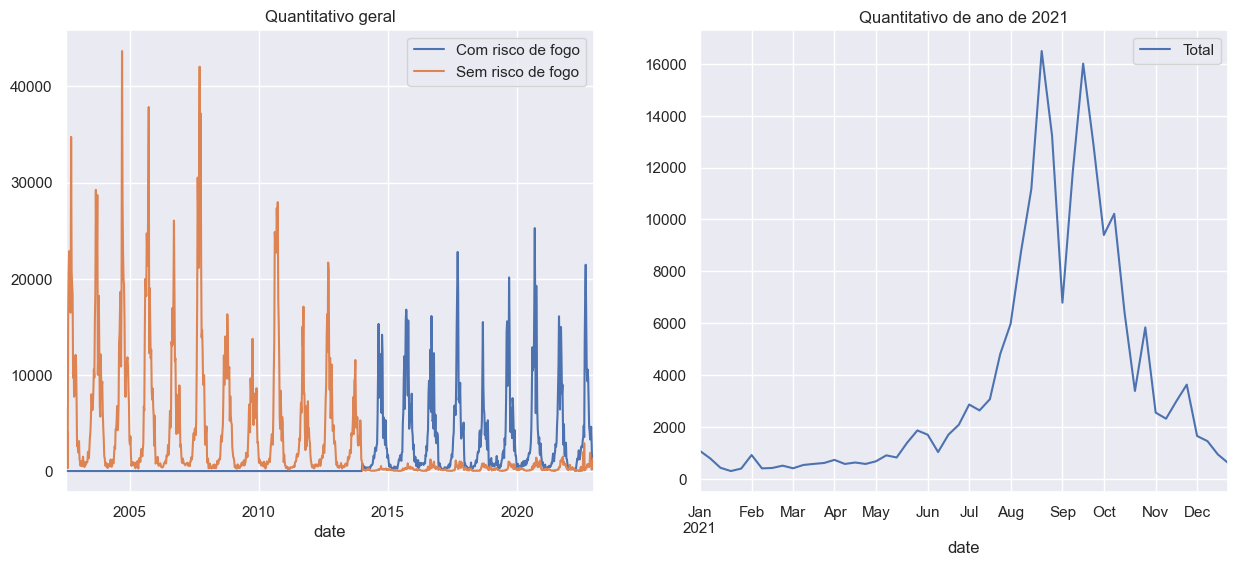

In [5]:
# analise quantitativa dos dados com relacao a flag risco de fogo
reference_df = df[(df.satelite == 'AQUA_M-T')].copy()

date_risco_counts = reference_df.loc[(df.riscofogo)].groupby(['date'])['date'].count()
date_risco_counts.name = 'Com risco de fogo'
date_sem_risco_counts = reference_df.loc[(df.riscofogo == False)].groupby(['date'])['date'].count()
date_sem_risco_counts.name = 'Sem risco de fogo'

daily_df = pd.concat([date_risco_counts, date_sem_risco_counts], axis=1).fillna(0).astype('int')
daily_df.index = pd.to_datetime(daily_df.index)
daily_df['Total'] = daily_df.iloc[:, 0] + daily_df.iloc[:, 1]
weekly_df = daily_df.resample('W').sum()

fig, axs = plt.subplots(1, 2, figsize=(15,6))
weekly_df.drop(['Total'], axis=1).plot(ax=axs[0], title='Quantitativo geral')
weekly_df.loc['2021'].plot(y='Total', ax=axs[1], title='Quantitativo de ano de 2021')

[Text(0, 0.5, '')]

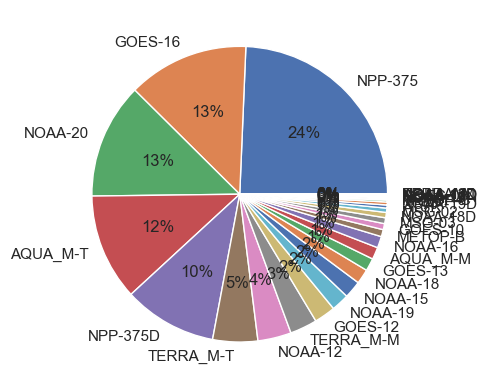

In [6]:
# análise quantitativa da proporsão de dados de cada satélite no dataset
fig, ax = plt.subplots()
df["satelite"].value_counts().plot(
    kind='pie', 
    ax=ax,
    autopct='%1.0f%%'
)
ax.set(ylabel=None)

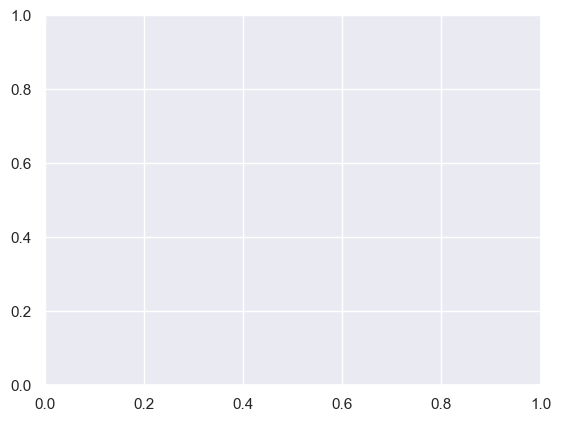

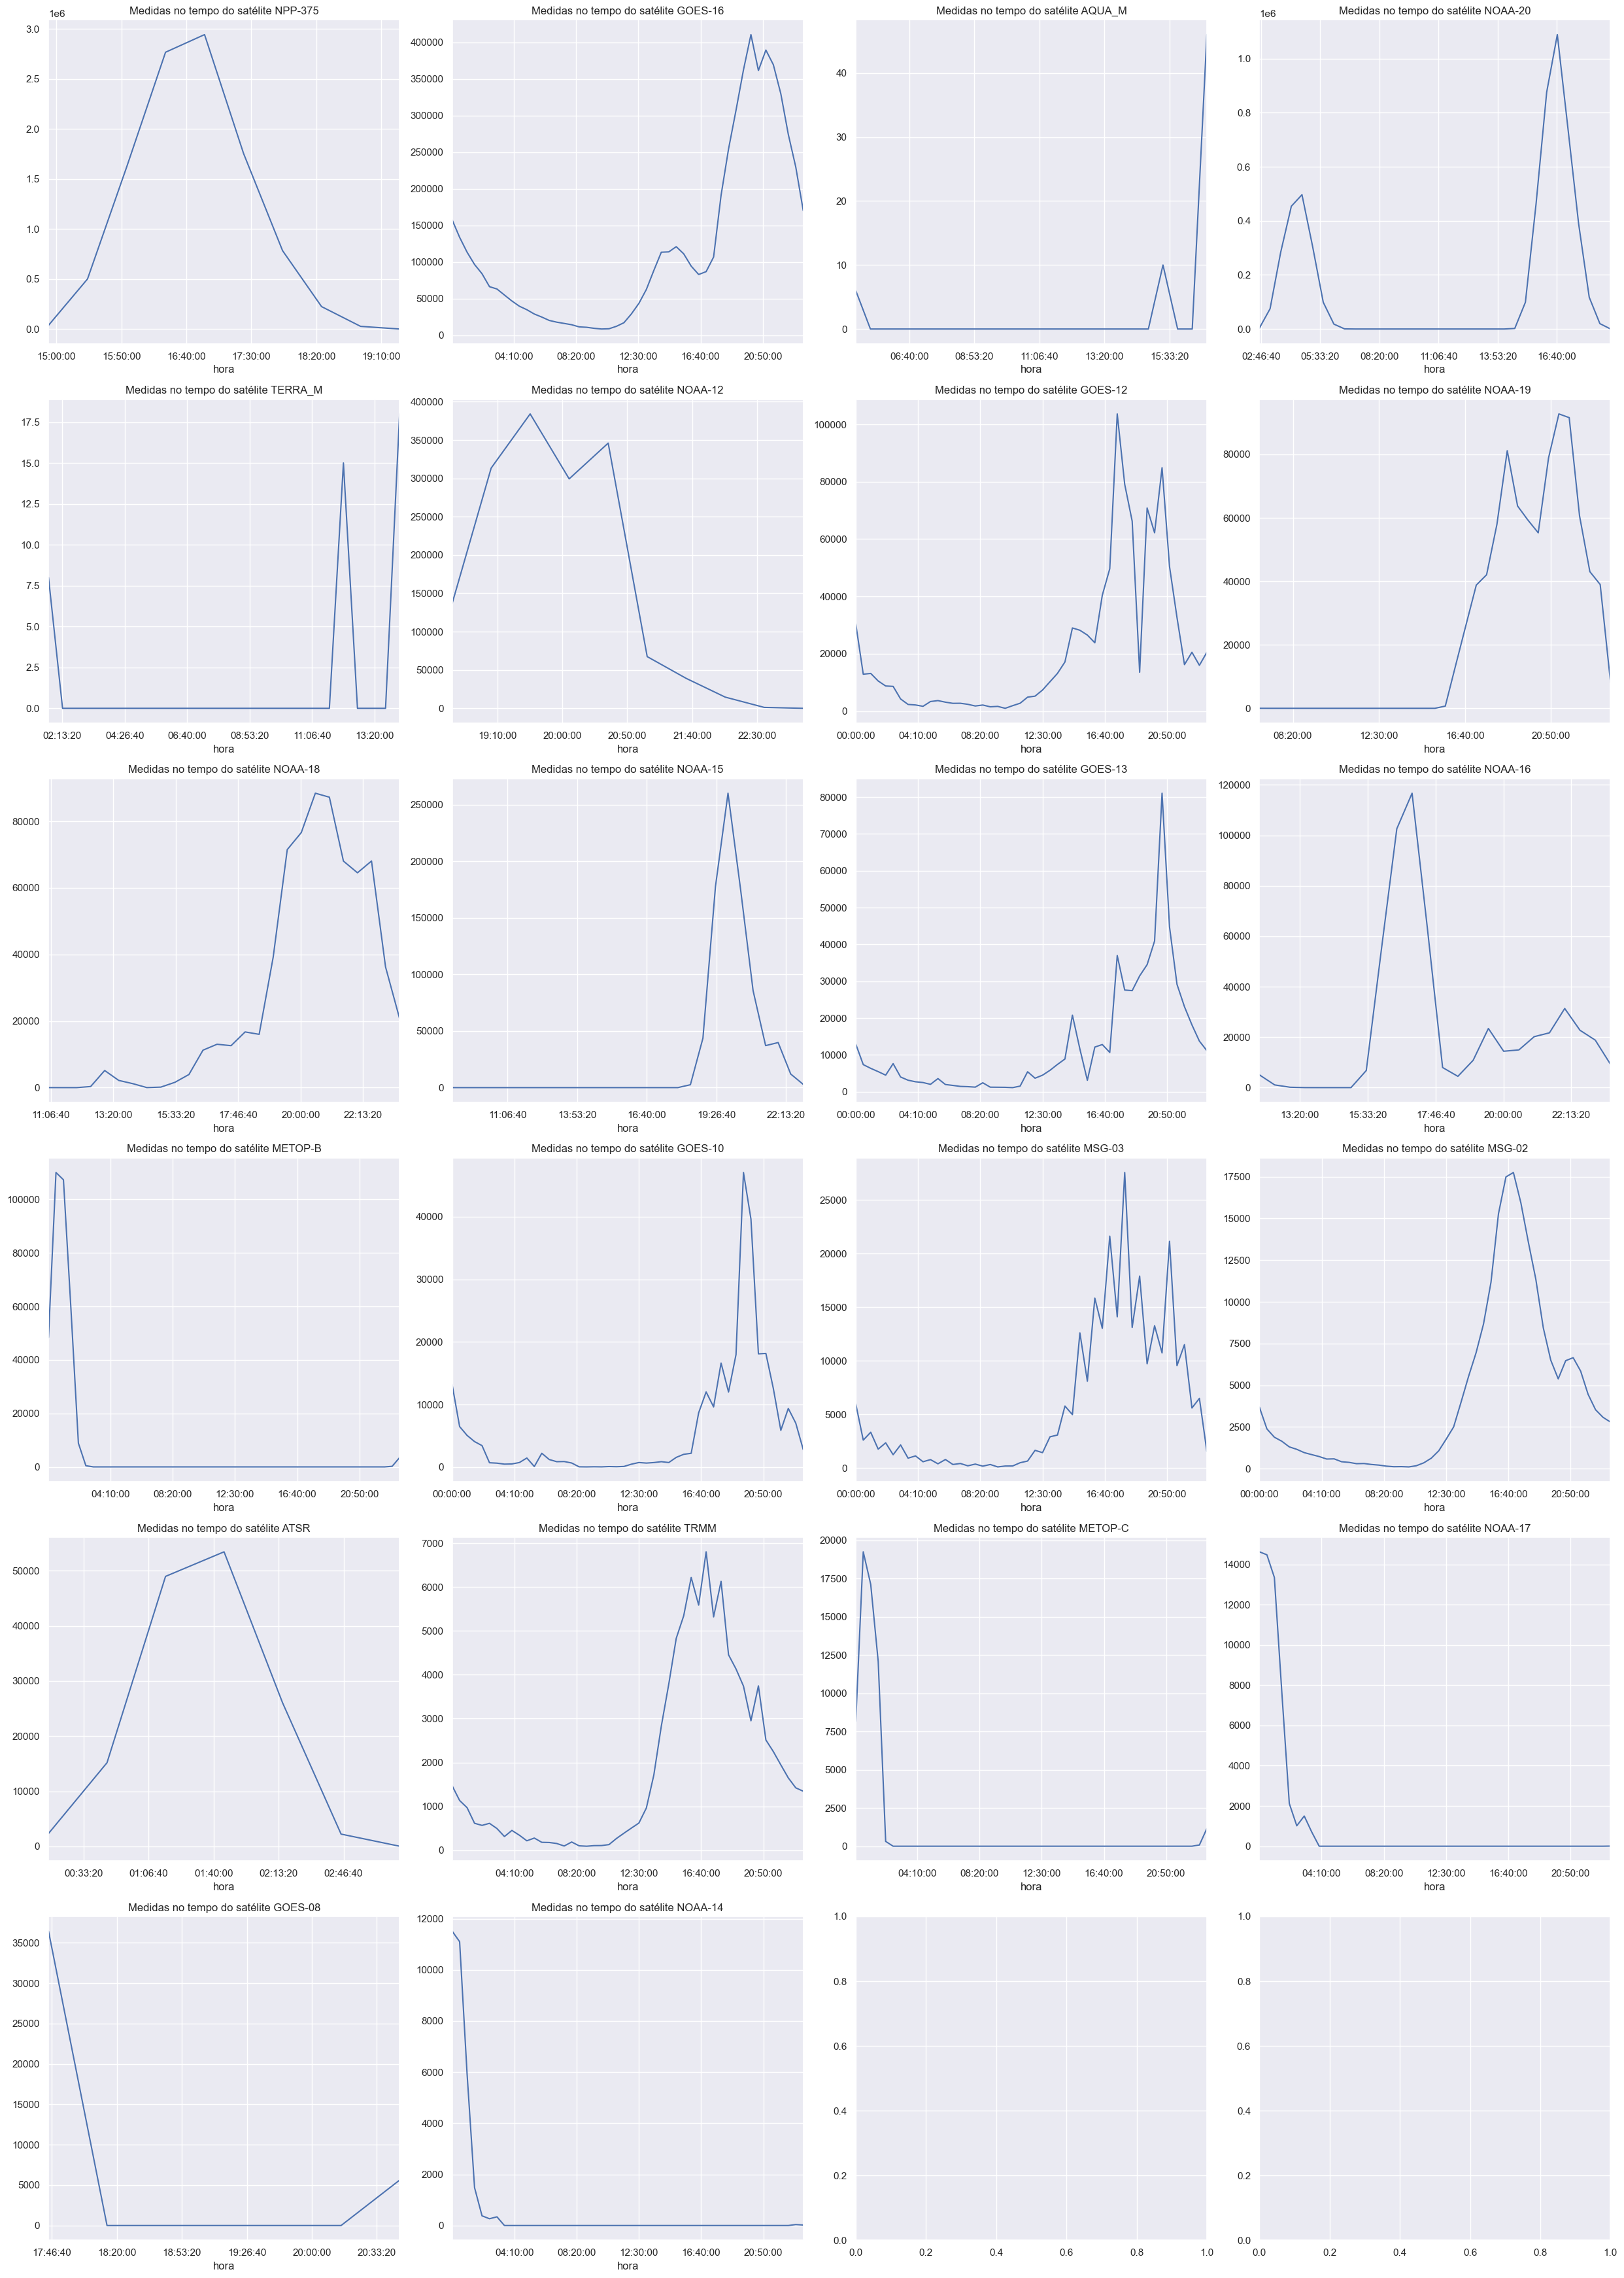

In [202]:
# analise do horários das medicoes dos satelites
from datetime import datetime, timedelta

def time_measure_dist(satelite='AQUA_M-T', ax=plt.axes()):
  time_counts = df[(df.satelite == satelite)].groupby(['hora'])['hora'].count()
  time_counts.index = pd.TimedeltaIndex(data=time_counts.index.astype('str'))
  time_counts = time_counts.resample('30min').sum().reindex()
  time_counts.plot(ax=ax)
  ax.xaxis.set_major_locator(plt.MaxNLocator(6))
  ax.set_title("Medidas no tempo do satélite {0}".format(satelite))

fig, axs = plt.subplots(6, 4, figsize=(25,35))
for i, ax in enumerate(axs.flat):
  if i < simp_satellites.size:
    time_measure_dist(simp_satellites[i], ax)

fig.tight_layout(h_pad=1, w_pad=0.5)


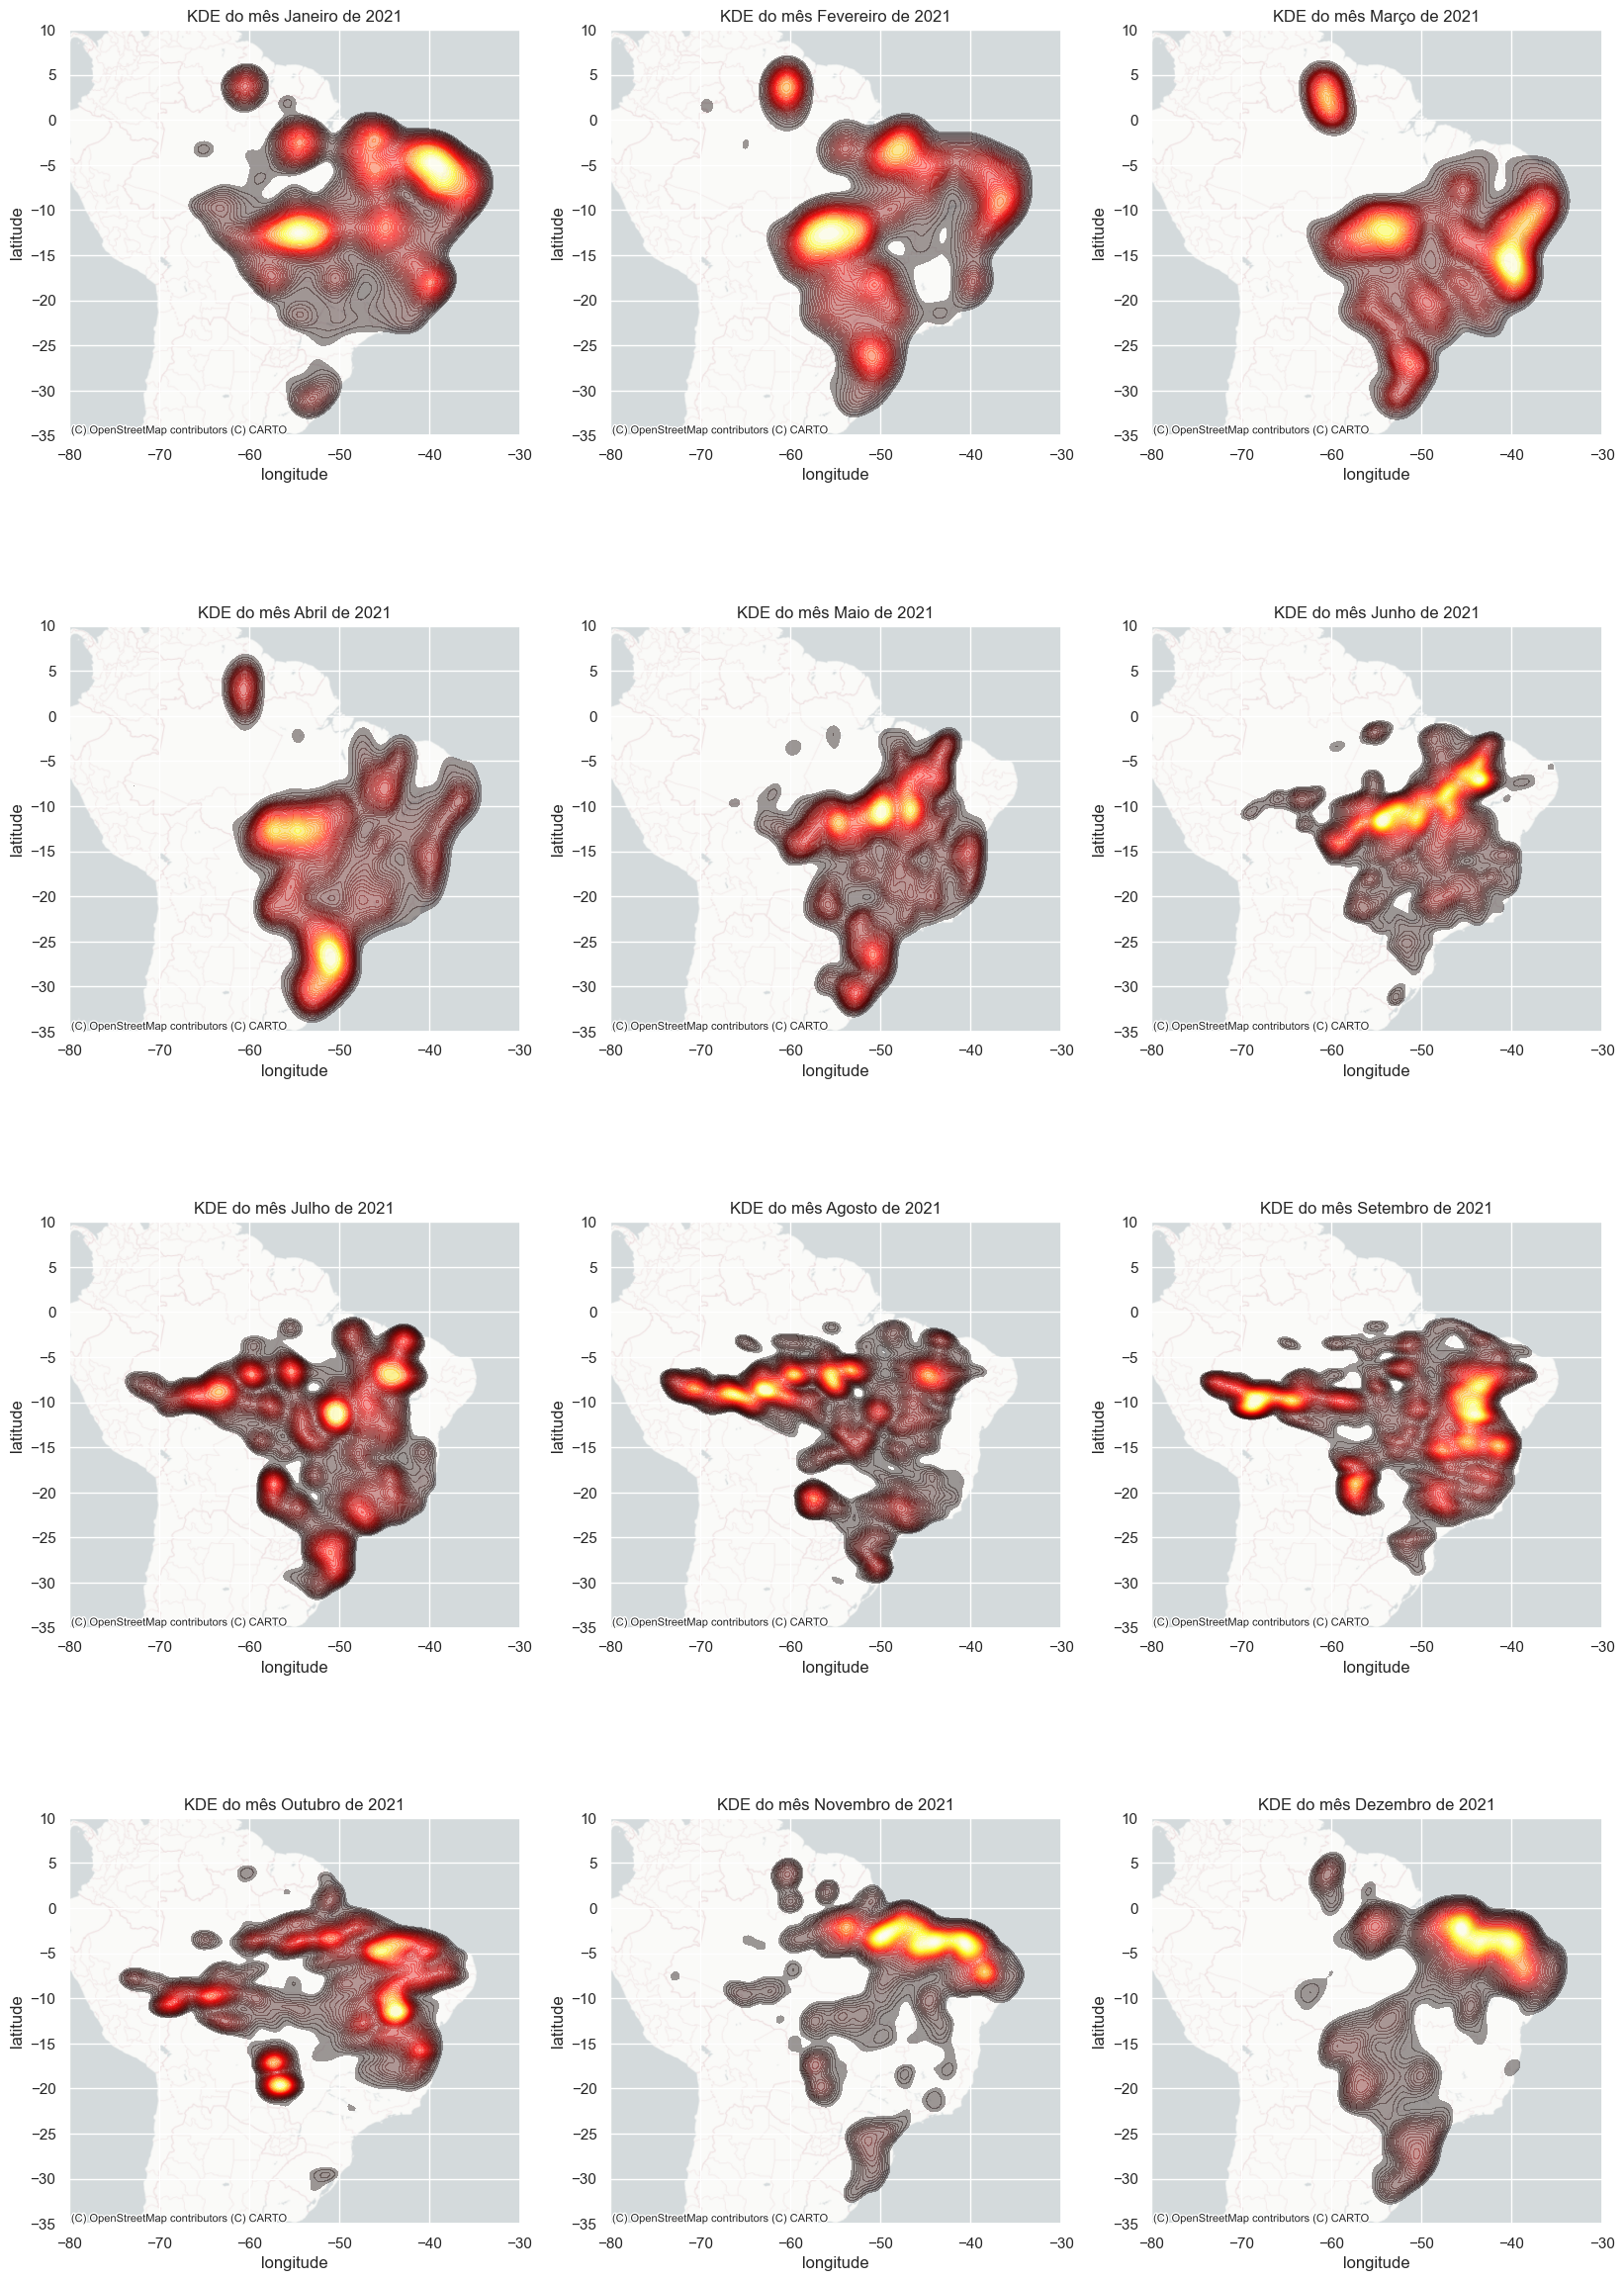

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(20, 30))
year = 2021
for i, ax in enumerate(axs.flat):
  month = i+1
  temp_df = reference_df.query('mes == {} and ano == {}'.format(month, year))
  ax.set_xlim([-80, -30])
  ax.set_ylim([-35, 10])
  sns.kdeplot(
      x=temp_df.longitude,
      y=temp_df.latitude,
      n_levels=50,
      fill=True,
      alpha=0.40,
      cmap="hot",
      bw_adjust=0.6,
      #cbar=True,
      ax=ax
  )
  ax.set_title("KDE do mês {} de {}".format(months_list[i], year))
  contextily.add_basemap(
      ax, 
      crs="EPSG:4326",
      source=contextily.providers.CartoDB.PositronNoLabels,
  )


In [180]:
# Utils functions

def sub_space(data: pd.DataFrame, min_lat: float, max_lat: float, min_lon: float, max_lon: float) -> pd.DataFrame:
    """Returns a sub data filtered by lat and lon boundary"""
    return data[(data['longitude'] >= min_lon) & (data['longitude'] <= max_lon) &
                (data['latitude'] >= min_lat) & (data['latitude'] <= max_lat)]

def split_by_range(data: pd.DataFrame, range: pd.DatetimeIndex, time_column='datahora') -> list[pd.DataFrame]:
    list = []
    if len(range) <= 1:
        return list
    for (i, current) in enumerate(range):
        if i < len(range) - 2:
            next = range[i+1]
            list.append(data[(data[time_column] >= current) & (data[time_column] < next)])
    return list

def compute_grid(data: pd.DataFrame, min_lat: float, max_lat: float, 
                 min_lon: float, max_lon: float, 
                 aggr_dist = distance.Distance(kilometers=1)) -> xarray.DataArray:
    # calculate the grid (agregate)
    width_bottom = distance.distance((min_lat, min_lon), (min_lat, max_lon))
    width_top = distance.distance((max_lat, min_lon), (max_lat, max_lon))

    height_left = distance.distance((min_lat, min_lon), (max_lat, min_lon))
    height_right = distance.distance((min_lat, max_lon), (max_lat, max_lon))

    width = max(width_top, width_bottom)
    height = max(height_left, height_right)

    cvs = datashader.Canvas(
        plot_width=int(width/aggr_dist), 
        plot_height=int(height/aggr_dist),
        x_range=(min_lon, max_lon),
        y_range=(min_lat, max_lat)
    )
    return cvs.points(data, x="longitude", y="latitude")

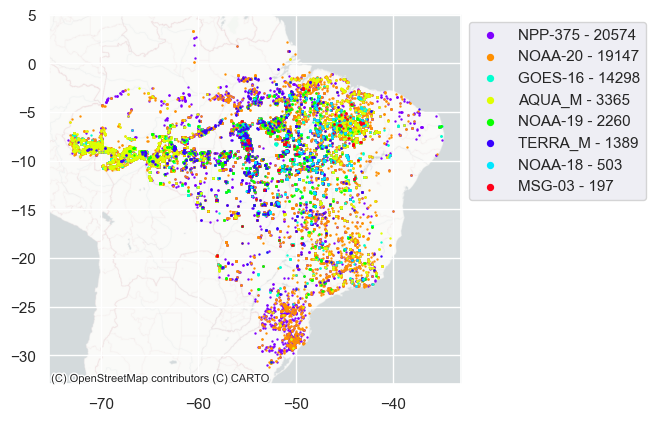

In [89]:
def show_satelites(data):
    fig, ax=plt.subplots()
    satelites_data = data['simp_satelite'].value_counts().where(lambda x : x != 0).dropna()
    for (i, satelite) in enumerate(satelites_data.index.tolist()):
        current = data[data['simp_satelite'] == satelite]
        gpd.GeoDataFrame(
            current,
            geometry=gpd.points_from_xy(current.longitude, current.latitude),
            crs="EPSG:4326"
        ).plot(
            ax=ax,
            color=satellites_colors[satelite],
            markersize=.5,
            label="{} - {}".format(satelite, int(satelites_data[satelite]))
        )
    contextily.add_basemap(
        ax, 
        crs="EPSG:4326",
        source=contextily.providers.CartoDB.PositronNoLabels,
    )
    legend = ax.legend(markerscale=6, bbox_to_anchor=(1.0, 1.0))

data_temp = df[(df.dia == 1) & (df.mes == 9) & (df.ano == 2022)]
show_satelites(data_temp)

In [225]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def show_grid_in_brasil(grid: xarray.DataArray, ax: plt.Axes):
    scale="10m"

    country_border = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale=scale,
        facecolor="none",
    )

    geographic_feature = cfeature.NaturalEarthFeature(
        category="physical",
        name="land",
        scale=scale,
        edgecolor='face',
        facecolor=cfeature.COLORS['land']
    )

    state_border = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale=scale,
        facecolor="none",
    )

    #  rect = patches.Rectangle((max_lat, max_lon), max_lon-min_lon, max_lat-min_lat, linewidth=1, edgecolor='r', facecolor='none')
    grid.plot(ax=ax, transform=ccrs.PlateCarree(), zorder=5)
    ax.set_xlim([-70, -35])
    ax.set_ylim([-30, 5])
    ax.add_feature(country_border, edgecolor="black", lw=2, zorder=4)
    ax.add_feature(state_border, edgecolor="black", lw=0.1, zorder=4)
    ax.add_feature(geographic_feature, zorder=3)
    ax.coastlines()
    ax.gridlines(draw_labels=True, zorder=6)

def show_grid(grid: xarray.DataArray, ax: plt.Axes): 
    grid.plot(ax=ax, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True)

def show_time_grid(data: pd.DataFrame, data_range: pd.DatetimeIndex, 
                   min_lat: float, max_lat: float, min_lon: float, max_lon: float, 
                   columns=2, width=20):
    data_space = sub_space(data, min_lat, max_lat, min_lon, max_lon)
    data_split = split_by_range(data_space, data_range)
    size = len(data_split) + 1
    rows = int(size/columns)
    print('Ploting with', size, 'Linhas', rows, '...')
    fig, axs = plt.subplots(rows, columns, figsize=(width, int((width-2)/columns) * rows), 
                            subplot_kw={'projection': ccrs.PlateCarree()})
    
    show_grid_in_brasil(
        xarray.DataArray([[0, 0], [0, 0]], dims=["latitude", "longitude"], coords={"longitude": [min_lon, max_lon], "latitude": [min_lat, max_lat]}), 
        axs.flat[0]
    )
    axs.flat[0].set_title("Brasil")
    for index, ax in enumerate(axs.flat[1:]):
        grid = compute_grid(data_split[index], min_lat, max_lat, min_lon, max_lon)
        show_grid(grid, ax)
        ax.set_title("{} até {}".format(data_range[index], data_range[index+1]))

    fig.tight_layout(h_pad=0.5, w_pad=0.5)

Ploting with 21 Linhas 10 ...


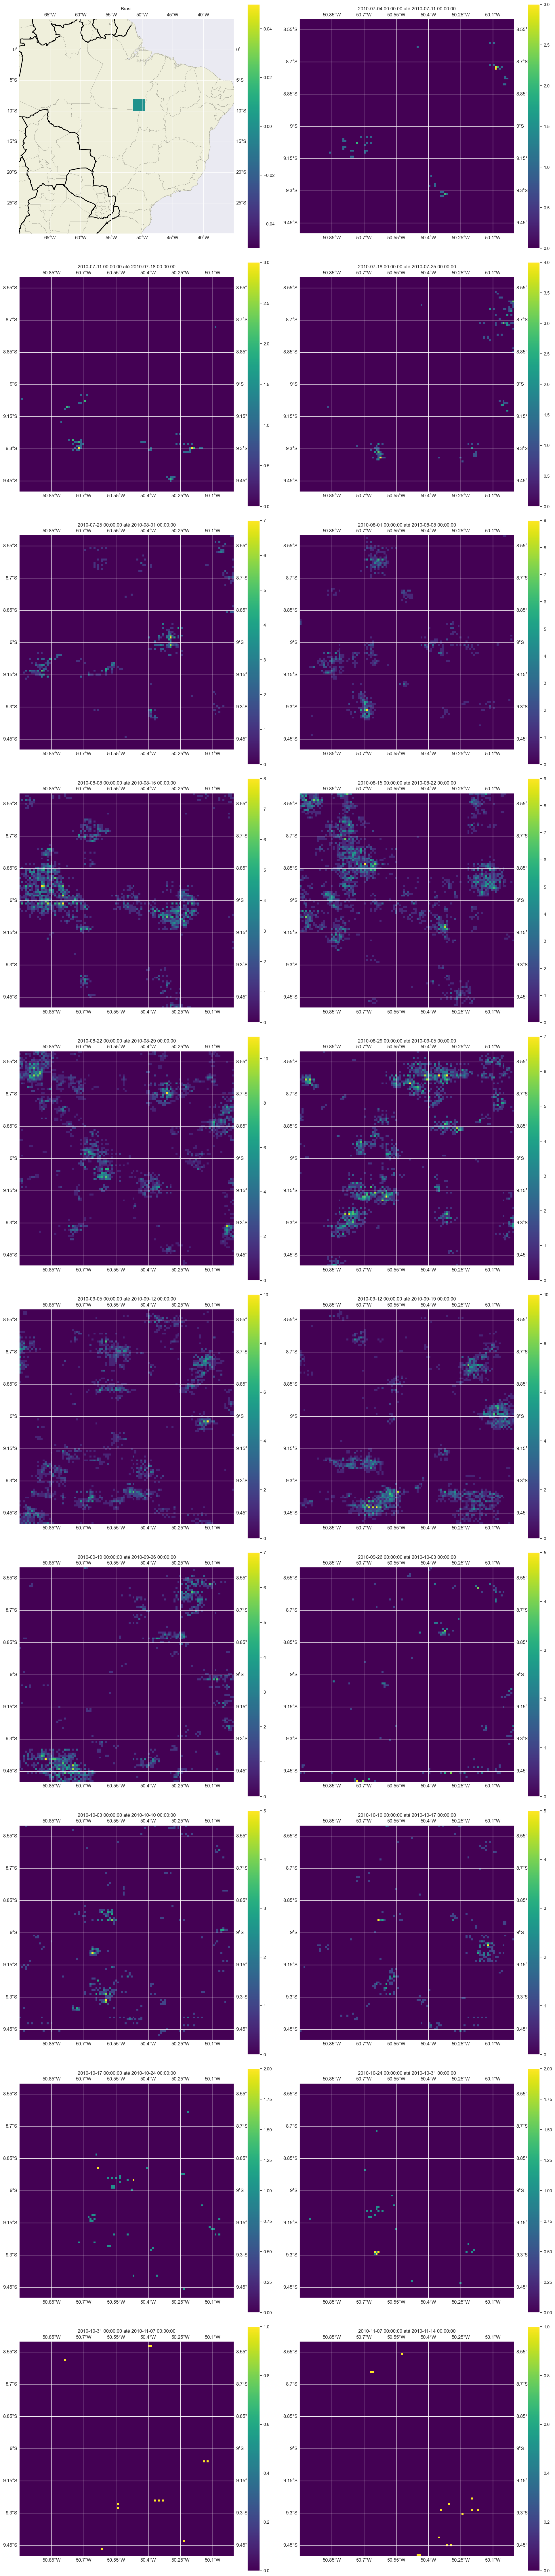

In [226]:
show_time_grid(df, pd.date_range("2010-07-01", freq="1W", periods=22), -9.5, -8.5, -51, -50)